# Volume 3: K-Means Clustering.
    Matthew Schaelling
    Math 405
    March 8, 2018

In [1]:
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
import numpy as np
from scipy import linalg as la
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D       # You might want this for Problem 2.
%matplotlib inline

In [2]:
plt.rcParams["figure.dpi"] = 200

## Problem 1

Write a `KMeans` class for doing basic $k$-means clustering.
Implement the following methods, following `sklearn` class conventions.
1. `__init__()`: Accept a number of clusters $k$, a maximum number of iterations, and a convergence tolerance.
Store these as attributes.

2. `fit()`: Accept an $m \times n$ matrix $X$ of $m$ data points with $n$ features.
Choose $k$ random rows of $X$ as the initial cluster centers.
Run the $k$-means iteration until consecutive centers are within the convergence tolerance, or until iterating the maximum number of times.
Save the cluster centers as attributes.
If a cluster is empty, reassign the cluster center as a random row of $X$.

3. `predict()`: Accept an $l \times n$ matrix $X$ of data.
Return an array of $l$ integers where the $i$th entry indicates which cluster center the $i$th row of $X$ is closest to.

Test your class on the iris data set (`sklean.datasets.load_iris()`) after reducing the data to two principal components (with `sklearn.decomposition.PCA`).
Plot the data, coloring by cluster.

In [3]:
class KMeans(BaseEstimator, ClusterMixin):
    """Basic k-means clustering class."""
    def __init__(self, n_clusters=8, max_iter=100, tol=1e-5, normalize=False):
        """Store clustering algorithm parameters.
        
        Parameters:
            n_clusters (int): How many clusters to compute.
            max_iter (int): The maximum number of iterations to compute.
            tol (float): The convergence tolerance.
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.normalize = normalize        # This is for Problem 2.
    
    def fit(self, X, y=None):
        """Compute the cluster centers from random initial conditions.
        
        Parameters:
            X ((n_samples, n_features) ndarray): the data to be clustered.
        """
        centers0 = X[np.random.choice(X.shape[0],self.n_clusters,replace=False)]
        centers1 = np.zeros_like(centers0)
        distances = np.ones((X.shape[0],self.n_clusters))*-1
        cluster_assignments = np.ones(X.shape[0])*-1
        for i in range(self.max_iter):
            for k in range(self.n_clusters):
                distances[:,k] = la.norm(X - centers0[k], ord=2, axis=1)
            cluster_assignments = np.argmin(distances, axis=1)
            for k in range(self.n_clusters):
                if k in np.unique(cluster_assignments):
                    centers1[k] = np.mean(X[cluster_assignments==k],axis=0)
                else:
                    centers1[k] = X[np.random.choice(X.shape[0],1)]
                if self.normalize:
                    centers1[k] = centers1[k]/la.norm(centers1[k], ord=2)
            if np.alltrue(la.norm(centers1 - centers0, ord=2, axis=1) < self.tol):
                break
            else:
                centers0 = centers1
        self.centers = centers1
        self.cluster_assignments = cluster_assignments
        return self
    
    def predict(self, X):
        """Classify each entry of X based on which cluster center it belongs to.

        Parameters:
            X ((n_samples, n_classes) ndarray): the data to be clustered.
        
        Returns:
            ((n_samples) ndarray): Integer labels from 0 to n_clusters for each entry of X.
        """
        distances = np.ones((X.shape[0], self.n_clusters))*-1
        for k in range(self.n_clusters):
            distances[:,k] = la.norm(X - self.centers[k], ord=2, axis=1)
        return np.argmin(distances, axis=1)
    
    def fit_predict(self, X, y=None):
        """Fit to the data and return the resulting labels.

        Parameters:
            X ((n_samples, n_classes) ndarray): the data to be clustered.
        """
        return self.fit(X).predict(X)

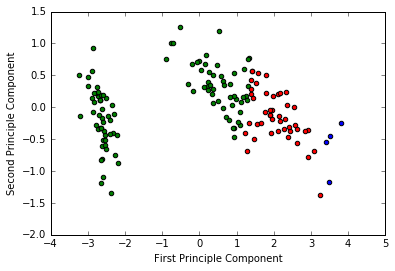

In [4]:
iris = load_iris()
kmeans = KMeans(n_clusters=3)
X = iris.data
pca = PCA(n_components=2)
Xnew = pca.fit_transform(X)
kmeans.fit(Xnew)
colors = {0:'g', 
          1:'b', 
          2:'r'}
for k in range(3):
    plt.scatter(Xnew[kmeans.cluster_assignments == k][:,0], 
                Xnew[kmeans.cluster_assignments == k][:,1], 
                c=colors[k])
plt.xlabel("First Principle Component")
plt.ylabel("Second Principle Component")
plt.show()

## Problem 2

Modify `KMeansfit()` so that if `normalize` is `True`, the cluster centers are normalized at each iteration.

Cluster the earthquake data in three dimensions by converting the data from spherical coordinates to euclidean coordinates on the sphere.
1. Convert longitude and latitude to radians, then to spherical coordinates.
(Hint: `np.deg2rad()` may be helpful.)
2. Convert the spherical coordinates to euclidean coordinates in $\mathbb{R}^3$.
3. Use your `KMeans` class with normalization to cluster the euclidean coordinates.
4. Translate the cluster center coordinates back to spherical coordinates, then to degrees.
5. Plot the data, coloring by cluster.
Also mark the cluster centers.

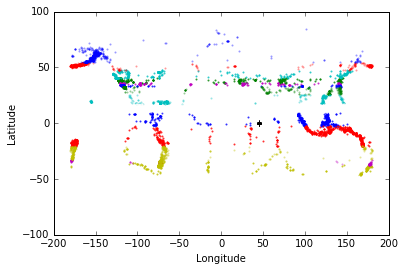

In [6]:
def long_lat_to_euclidean(X):    
    X = np.deg2rad(X)
    theta = np.pi*X[:,0]/180.
    phi = np.pi*(90 - X[:,1])/180.
    euclidean = np.zeros((X.shape[0],3))
    euclidean[:,0] = np.sin(phi)*np.cos(theta) # x coordinate
    euclidean[:,1] = np.sin(phi)*np.sin(phi)   # y coordinate
    euclidean[:,2] = np.cos(phi)               # z coordinate
    return euclidean

def euclidean_to_long_lat(X):
    phi = np.arccos(X[:,2])
    theta = np.arctan2(X[:,1],X[:,0])
    long_lat = np.zeros((X.shape[0],2))
    long_lat[:,0] = 180*theta/np.pi
    long_lat[:,1] = 90. - (180*phi/np.pi)
    return long_lat

earthquakes = np.load('earthquake_coordinates.npy')
euclidean = long_lat_to_euclidean(earthquakes)
kmeans2 = KMeans(n_clusters=15, normalize=True)
kmeans2.fit(euclidean)
centers = euclidean_to_long_lat(kmeans2.centers)
cluster_assignments = kmeans2.cluster_assignments
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'w']*3

for k in range(15):
    if k < 8:
        plt.scatter(earthquakes[cluster_assignments == k][:,0], 
                    earthquakes[cluster_assignments == k][:,1], 
                    alpha=.8, linewidths=0, c=colors[k], s=4)
    else:
        plt.scatter(earthquakes[cluster_assignments == k][:,0], 
                    earthquakes[cluster_assignments == k][:,1], 
                    alpha=.4, linewidths=0, c=colors[k], s=4)
    plt.scatter(centers[k,0], centers[k,1], marker='+', c='k')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## Problem 3

Write a function that accepts an image array (of shape $(m,n,3)$), an integer number of clusters $k$, and an integer number of samples $S$.
Reshape the image so that each row represents a single pixel.
Choose $S$ pixels to train a $k$-means model on with $k$ clusters.
Make a copy of the original picture where each pixel has the same color as its cluster center.
Return the new image.
For this problem, you may use `sklearn.cluster.KMeans` instead of your `KMeans` class.

Test your function on some of the provided NASA images.

In [ ]:
def quantize_image(im, n_clusters=4, n_samples=50):
    """Cluster the pixels of the image 'im' by color.
    Return a copy of the image where each pixel is replaced by the value
    of its cluster center.
    
    Parameters:
        im ((m,n,3) ndarray): an image array.
        n_clusters (int): the number of k-means clusters.
        n_samples (int): the number of pixels to train the k-means model on.
    
    Returns:
        ((m,n,3) ndarray): the quantized image.
    """
    raise NotImplementedError("Problem 3 Incomplete")